# Variational Autoencoder
- Using Simple Neural Network 
- Variational Inference
- [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114)

## 1. Settings

In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Data

In [15]:
mnist_train = dset.MNIST("./data/MNIST", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./data/MNIST", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

In [16]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=False,num_workers=2,drop_last=True)

## 3. Model

In [39]:
hidden_size = 50
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
#         self.fc0 = nn.Sequential(nn.Linear(784,784),
#                       nn.ReLU(),
#                       nn.Linear(784,784),
#                       nn.ReLU())
        self.fc1_1 = nn.Linear(784, hidden_size)
        self.fc1_2 = nn.Linear(784, hidden_size)
        self.relu = nn.ReLU()
        
    def encode(self,x):
        x = x.view(batch_size,-1)
#        x = self.fc0(x)       
        mu = self.relu(self.fc1_1(x))
        log_var = self.relu(self.fc1_2(x))                
        return mu, log_var
    
    def forward(self,x):
        mu, logvar = self.encode(x)
        
        noise = torch.randn(mu.size()).cuda()
        z = mu + logvar.mul(0.5).exp() * noise        
        
        return z, mu, logvar
        
encoder = Encoder().cuda()

In [40]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        
#         self.fc0 = nn.Sequential(nn.Linear(hidden_size,hidden_size),
#                     nn.ReLU(),
#                     nn.Linear(hidden_size,hidden_size),
#                     nn.ReLU())      
        self.fc1 = nn.Linear(hidden_size, 784)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self,x):
#        x = self.fc0(x)
        out = self.fc1(x)
        out = self.sigmoid(out)
        out = out.view(batch_size,1,28,28)
        
        return out
        
decoder = Decoder().cuda()

## 4. Loss func & Optimizer

In [41]:
reconstruction_function = nn.BCELoss(size_average=False)

def loss_function(recon_x, x, mu, logvar):
    BCE = reconstruction_function(recon_x, x)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    return BCE + KLD

import itertools
parameters = itertools.chain(encoder.parameters(),decoder.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.0005)

/home/isjeon/anaconda3/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


## 5. Train 

In [46]:
# try:
#     encoder, decoder = torch.load('./model/variational_autoencoder.pkl')
#     print("\n--------model restored--------\n")
# except:
#     print("\n--------model not restored--------\n")
#     pass
num_epoch = 10

for i in range(num_epoch):
    for j,(image,label) in enumerate(train_loader):
        optimizer.zero_grad()
        
        image = image.cuda()
        z, mu, log_var = encoder(image)
        output = decoder(z)
        
        loss = loss_function(output, image, mu, log_var)
        
        loss.backward()
        optimizer.step()

#         if j % 100 == 0:
#             torch.save([encoder,decoder],'./model/variational_autoencoder.pkl')
#             print(loss)
    print("loss is", loss.item())        


loss is 20288.509765625
loss is 20096.333984375
loss is 19585.828125
loss is 20110.677734375
loss is 19397.09375
loss is 19847.33203125
loss is 20410.486328125
loss is 19253.6015625
loss is 19331.998046875
loss is 20108.58984375


## 6. Check with Train Image

torch.Size([128, 28, 28])


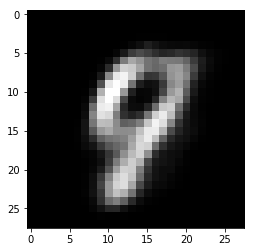

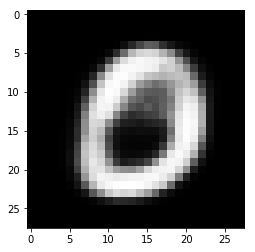

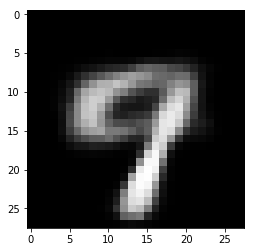

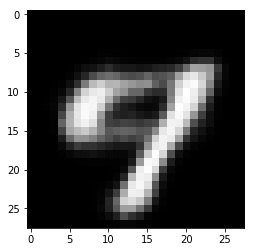

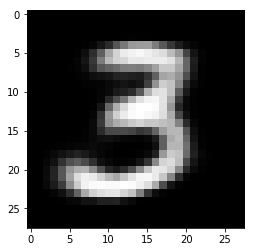

In [47]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
    #plt.imshow(torch.squeeze(image[i]).numpy(),cmap='gray')
    #plt.show()
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()

In [48]:
for i in range(1):
    for j, (image,label) in enumerate(test_loader):
       
        image = image.cuda()
        output,mean,var = encoder(image)
        output = decoder(output)
        
    if j % 10 == 0:
        print(loss)        

torch.Size([128, 28, 28])


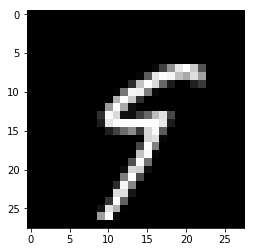

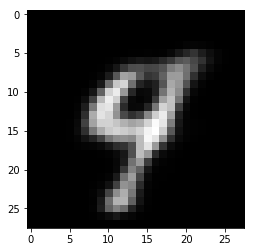

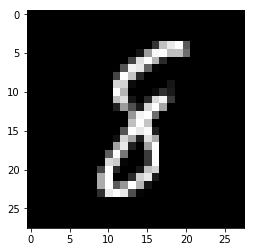

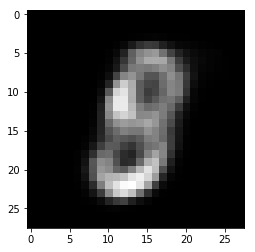

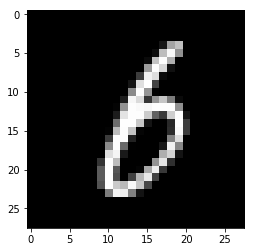

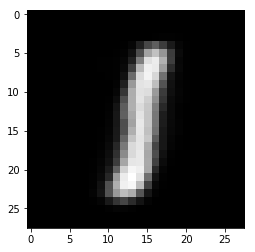

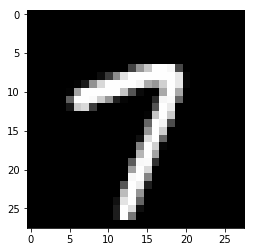

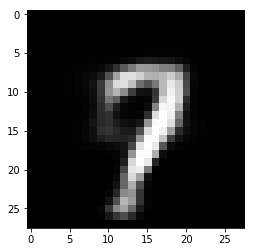

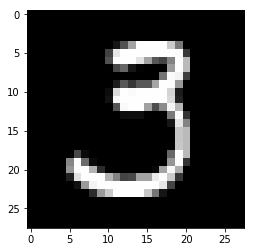

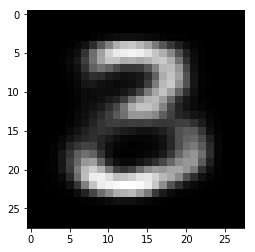

In [49]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
    plt.imshow(torch.squeeze(image[i].cpu()).data.numpy(),cmap='gray')
    plt.show()
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()